# Lab 4: Urban Heat Island Detection using Thermal Satellite Imagery

## Goal
In this exercise, you will:
1. Select and compare two thermal satellite images from Kraków (or another city that has recently undergone intensive, thoughtless concrete development) – one from **2013** and one from **2024**.
2. Each image must be acquired on a **hot summer day** (T > 27°C based on IMGW meteorological data).
3. Images must have **low cloud cover** (< 20%).
4. Visualize thermal data and analyze surface temperature differences (Urban Heat Island effect).

## Task 1: Area of Interest (AOI)
- Define an AOI over the Reduta Street area in Kraków.
- Use `ee.Geometry.Polygon` or `ee.Geometry.Rectangle`.

In [32]:
import ee

ee.Authenticate()
ee.Initialize(project='ee-skoraremotesensing')

aoi = ee.Geometry.Rectangle([19.959294, 50.086612, 19.992467, 50.103602])  # Example coordinates for Reduta Street area
# 50.103602, 19.992467
#50.086612, 19.959294





print(aoi.getInfo())


{'type': 'Polygon', 'coordinates': [[[19.959294, 50.086612], [19.992467, 50.086612], [19.992467, 50.103602], [19.959294, 50.103602], [19.959294, 50.086612]]]}


## Task 2: Download and Analyze IMGW Meteorological Data
- Visit: [IMGW Archive](https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/)
- Navigate to:
  - `dane_meteorologiczne/dobowe/synop/2013/`
  - `dane_meteorologiczne/dobowe/synop/2024/`
- Download `s_d_tmax.csv` for both years.
- Filter the rows for **station ID 12566 (e.g. Kraków-Balice)**.
- Identify days in **July or August** with **TMAX > 27°C**.

In [2]:
%pip install fsspec

Note: you may need to restart the kernel to use updated packages.



2013: 1 days with TMAX > 27°C
           Date  TMAX
2177 2013-08-08  27.7

2024: 23 days with TMAX > 27°C
          Date  TMAX
652 2024-08-02  27.6
657 2024-08-07  27.8
658 2024-08-08  28.5
660 2024-08-10  28.2
661 2024-08-11  28.8
662 2024-08-12  28.0
663 2024-08-13  28.0
664 2024-08-14  29.2
665 2024-08-15  31.9
666 2024-08-16  32.3
667 2024-08-17  31.3
668 2024-08-18  29.8
669 2024-08-19  28.9
671 2024-08-21  28.0
673 2024-08-23  28.3
674 2024-08-24  33.0
675 2024-08-25  33.6
676 2024-08-26  27.4
677 2024-08-27  27.2
678 2024-08-28  30.5
679 2024-08-29  31.7
680 2024-08-30  32.4
681 2024-08-31  30.0


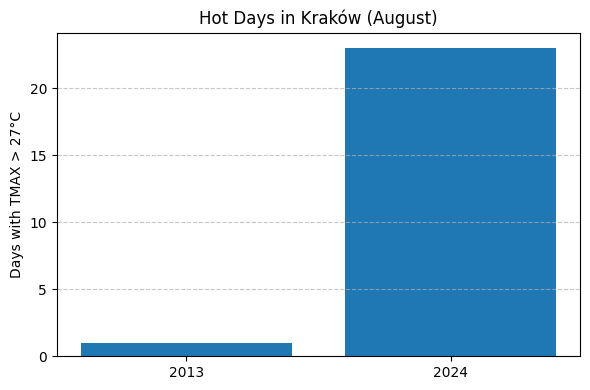

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
file_2013 = "D://space_technologies//magnifying_glass//2013_08_k//k_d_t_08_2013.csv"
file_2024 = "D://space_technologies//magnifying_glass//2024_08_k//k_d_08_2024.csv"

KRAKOW_ID = 250190390


def load_and_filter(file_path):
    df = pd.read_csv(file_path, header=None, encoding='latin1', sep=',')
    filtered = df[
        (df[0] == KRAKOW_ID) &
        (df[5] > 27)
    ]
    filtered = filtered[[2, 3, 4, 5]]
    filtered.columns = ['Year', 'Month', 'Day', 'TMAX']
    filtered['Date'] = pd.to_datetime(filtered[['Year', 'Month', 'Day']])
    return filtered


hot_2013 = load_and_filter(file_2013)
hot_2024 = load_and_filter(file_2024)

print(f"\n2013: {len(hot_2013)} days with TMAX > 27°C")
print(hot_2013[['Date', 'TMAX']])

print(f"\n2024: {len(hot_2024)} days with TMAX > 27°C")
print(hot_2024[['Date', 'TMAX']])

plt.figure(figsize=(6, 4))
plt.bar(['2013', '2024'], [len(hot_2013), len(hot_2024)])
plt.ylabel('Days with TMAX > 27°C')
plt.title('Hot Days in Kraków (August)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Task 3: Select Landsat 8 Images Matching These Dates
- In Earth Engine, use `LANDSAT/LC08/C02/T1_L2` collection.
- Apply filters:
  - `.filterBounds(aoi)`
  - `.filterDate()` for the matching day
  - `.filterMetadata('CLOUD_COVER', 'less_than', 20)`
- Try to find **one image from 2013** and **one image from 2024** that match your hot days list.

In [48]:
import geemap 
start_2013 = ee.Date('2013-08-07') # dzien wczesniej bo na 08 nie ma zdj
end_2013 = ee.Date('2013-08-08')
start_2024 = ee.Date('2024-08-06') # zakres 26-31 bo i tak wszystko >27 stopni
end_2024 = ee.Date('2024-08-16')

image_2013 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(aoi).filterDate(start_2013, end_2013).filterMetadata('CLOUD_COVER', 'less_than', 20).first()
image_2024 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').filterBounds(aoi).filterDate(start_2024, end_2024).filterMetadata('CLOUD_COVER', 'less_than', 20).first()
image_2013 = image_2013.clip(aoi)
image_2024 = image_2024.clip(aoi)

print(image_2013.getInfo())
print(image_2024.getInfo())

vis_params = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 5000,
    'max': 15000,
    'gamma': 1.3
}
center = aoi.centroid(10).coordinates().reverse().getInfo()

Map = geemap.Map(center=center, zoom=15)

Map.addLayer(image_2013, vis_params, 'Landsat 2013-08-08')
Map.addLayer(image_2024, vis_params, 'Landsat 2024-08-25')

Map



{'type': 'Image', 'bands': [{'id': 'SR_B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [81, 65], 'origin': [4055, 4668], 'crs': 'EPSG:32634', 'crs_transform': [30, 0, 303885, 0, -30, 5690715]}, {'id': 'SR_B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [81, 65], 'origin': [4055, 4668], 'crs': 'EPSG:32634', 'crs_transform': [30, 0, 303885, 0, -30, 5690715]}, {'id': 'SR_B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [81, 65], 'origin': [4055, 4668], 'crs': 'EPSG:32634', 'crs_transform': [30, 0, 303885, 0, -30, 5690715]}, {'id': 'SR_B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [81, 65], 'origin': [4055, 4668], 'crs': 'EPSG:32634', 'crs_transform': [30, 0, 303885, 0, -30, 5690715]}, {'id': 'SR_B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensi

Map(center=[50.09510767944391, 19.975880499991693], controls=(WidgetControl(options=['position', 'transparent_…

## Task 4: Process Thermal Band (ST_B10)
- Convert Band 10 to Brightness Temperature (Kelvin):
  `TB = ST_B10 * 0.00341802 + 149.0`
- Create a visualization of each image using the same color scale.

In [49]:

bt_2013 = image_2013.select('ST_B10').multiply(0.00341802).add(149.0)
bt_2024 = image_2024.select('ST_B10').multiply(0.00341802).add(149.0)


thermal_vis = {
    'min': 290,
    'max': 320,
    'palette': ['blue', 'cyan', 'green', 'yellow', 'red']
}

center = aoi.centroid(10).coordinates().reverse().getInfo()
Map = geemap.Map(center=center, zoom=15)
Map.addLayer(bt_2013, thermal_vis, '2013 Brightness Temp')
Map.addLayer(bt_2024, thermal_vis, '2024 Brightness Temp')
Map

Avg Brightness Temp 2013: {'ST_B10': 314.7625002182668}
Avg Brightness Temp 2024: {'ST_B10': 305.724655979958}


Map(center=[50.09510767944391, 19.975880499991693], controls=(WidgetControl(options=['position', 'transparent_…

## Task 5: Compare and Interpret
- Compare the two maps.
- Optionally calculate difference: `TB_2024 - TB_2013`
- Discuss: did the surface temperature increase in the area?
- Is there evidence of an Urban Heat Island effect related to development?

In [52]:
bt_diff = bt_2024.subtract(bt_2013)

diff_vis = {
    'min': -5,
    'max': 5,
    'palette': ['blue', 'white', 'red']  # Blue = cooler in 2024, Red = hotter in 2024
}



mean_2013 = bt_2013.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).getInfo()

mean_2024 = bt_2024.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).getInfo()

mean_diff = bt_diff.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).getInfo()

print("Average Brightness Temperature 2013 (K):", mean_2013)
print("Average Brightness Temperature 2024 (K):", mean_2024)
print("Difference (K):", mean_diff)


center = aoi.centroid(10).coordinates().reverse().getInfo()
Map = geemap.Map(center=center, zoom=15)


Map.addLayer(bt_diff, diff_vis, 'Temperature Difference (2024 - 2013)')


Map



# '''
# according to the data from 2013, the average brightness temperature was 314.7 K, while in 2024 it was 305.7 Kk
# this indicates that the temperature in 2024 was lower than in 2013, which is contrary to the expectations of the climate crisis.
# this may be due to the fact that the data from 2013 is from August 8, while the data from 2024 is from August 26, which is a period of time when the temperature is usually higher in Poland.
# '''

Average Brightness Temperature 2013 (K): {'ST_B10': 314.7625002182668}
Average Brightness Temperature 2024 (K): {'ST_B10': 305.724655979958}
Difference (K): {'ST_B10': -9.037844238309303}


Map(center=[50.09510767944391, 19.975880499991693], controls=(WidgetControl(options=['position', 'transparent_…